In [29]:
from sena.data.norec.dataloader import load_full_dataset
import sena.utils.preprocessing as preprocessing
import pandas as pd

In [30]:
data = load_full_dataset()

train = data["train"].copy()
val = data["dev"].copy()
test = data["test"].copy()

train["label"] = train["label"].replace({0: "negative", 1: "neutral", 2: "positive"})
val["label"] = val["label"].replace({0: "negative", 1: "neutral", 2: "positive"})
test["label"] = test["label"].replace({0: "negative", 1: "neutral", 2: "positive"})

train = train.sample(frac=1)
val = val.sample(frac=1)
test = test.sample(frac=1)

train = preprocessing.clean_text(train, "text")
val = preprocessing.clean_text(val, "text")
test = preprocessing.clean_text(test, "text")

combined_data = pd.concat([train.copy(), val.copy(), test.copy()])

In [31]:
from collections import Counter
import math

num_words = Counter()
for review in combined_data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words) / 20
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 26000


<AxesSubplot:>

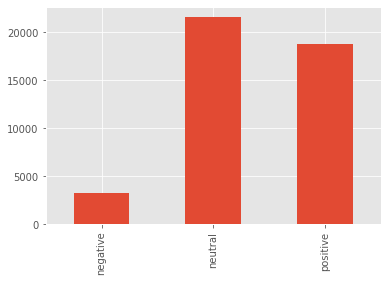

In [32]:
combined_data["label"].value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

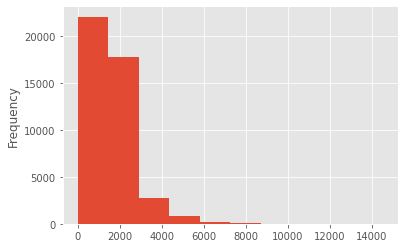

In [33]:
combined_data["text"].str.len().plot.hist()

In [34]:
average_text_length = combined_data["text"].str.len().mean()
max_text_length = combined_data["text"].str.len().max()
print("Average text length:", int(average_text_length))
print("Max text length:", int(max_text_length))

Average text length: 1623
Max text length: 14505


In [35]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import numpy as np

X_train, y_train = train["text"], train["label"]
X_val, y_val = val["text"], val["label"]
X_test, y_test = test["text"], test["label"]

maxlen = (int(np.ceil(np.mean([len(text.split()) for text in combined_data.text]))))

tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(combined_data["text"].tolist())

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=maxlen, padding="post", truncating="post")

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=maxlen, padding="post", truncating="post")

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen, padding="post", truncating="post")

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(combined_data["label"].tolist())

y_train = np.array(label_tokenizer.texts_to_sequences(y_train))
y_val = np.array(label_tokenizer.texts_to_sequences(y_val))
y_test = np.array(label_tokenizer.texts_to_sequences(y_test))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape, end="\n\n")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape, end="\n\n")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34903, 204)
y_train shape: (34903, 1)

X_val shape: (4360, 204)
y_val shape: (4360, 1)

X_test shape: (4351, 204)
y_test shape: (4351, 1)


In [36]:
from collections import Counter

combined_text = tokenizer.texts_to_sequences(combined_data["text"])

word_counter = Counter()
for review in combined_text:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [37]:
word_counter.most_common(10)

[('<OOV>', 1456494),
 ('litt', 35145),
 ('får', 34541),
 ('gjør', 27955),
 ('helt', 27035),
 ('godt', 26690),
 ('filmen', 26493),
 ('år', 25426),
 ('alt', 23592),
 ('nok', 23554)]

In [38]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

model = Sequential()
model.add(Embedding(num_words, 64))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(4, activation='softmax'))

In [39]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          1664000   
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1,730,564
Trainable params: 1,730,564
Non-trainable params: 0
_________________________________________________________________


In [40]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop])

Epoch 1/20
1091/1091 [==============================] - 166s 149ms/step - loss: 0.8148 - accuracy: 0.6027 - val_loss: 0.7541 - val_accuracy: 0.6413
Epoch 2/20
1091/1091 [==============================] - 156s 143ms/step - loss: 0.5841 - accuracy: 0.7479 - val_loss: 0.6984 - val_accuracy: 0.6787
Epoch 3/20
1091/1091 [==============================] - 164s 151ms/step - loss: 0.4069 - accuracy: 0.8368 - val_loss: 0.8557 - val_accuracy: 0.6239
Epoch 4/20
1091/1091 [==============================] - 169s 155ms/step - loss: 0.2436 - accuracy: 0.9083 - val_loss: 1.0780 - val_accuracy: 0.6493
Epoch 5/20
1091/1091 [==============================] - 172s 158ms/step - loss: 0.1405 - accuracy: 0.9506 - val_loss: 1.2696 - val_accuracy: 0.6289


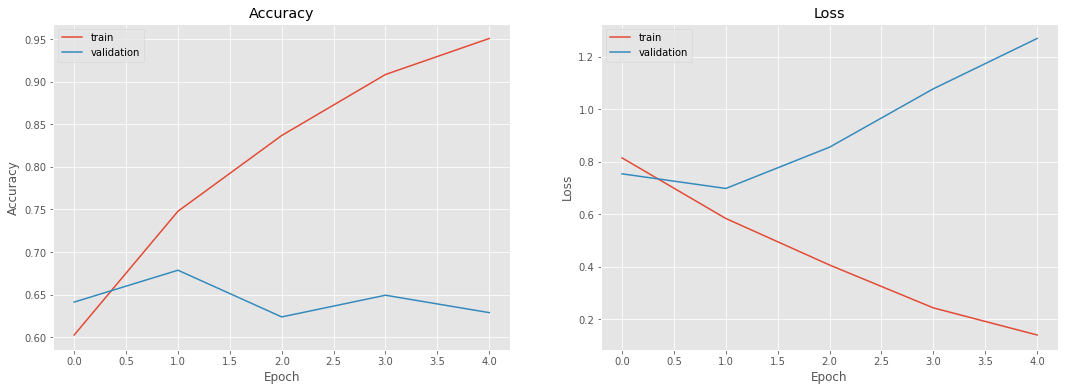

In [41]:
from sena.utils.visualization import plot_history

plot_history(history)

In [42]:
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

136/136 [==============================] - 7s 52ms/step - loss: 1.2718 - accuracy: 0.6396
Validation loss: 1.2717713117599487
Validation accuracy: 0.6396230459213257


In [43]:
from datetime import datetime

if val_acc > 0.8:
    model.save(f"models/SA-LSTM-MULTICLASS-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")